In [127]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [128]:
import editdistance
from IPython.display import clear_output
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import simdna
from simdna import synthetic
import torch

from pyx.one_hot import one_hot
from tf_coop_model import CountsRegressor, IterablePandasDataset
from tf_coop_model import anscombe_transform, run_one_epoch, pearson_r, spearman_rho, rsquared
from tf_coop_simulation import background_frequency, simulate_oracle_predictions

# Initialize Model & Load Weights
This step assumes we've trained a counts regression model and have its weights stored in a .pt[h] file somewhere accessible.

In [129]:
n_conv_layers = 3
n_dense_layers = 3
n_outputs = 2
sequence_length = 100
filters = 15
filter_width = 7
dense_layer_width = 30

weights_fpath = '../dat/sim/cnn_counts_predictor.pt'
test_data_fpath = '../dat/sim/test_labels.csv'
raw_simulation_data_fpath = '../dat/sim/test_sequences.simdata'

exposure_motif = "GATA_disc1"
outcome_motif = "TAL1_known1"

sequences_col = "sequences"
label_cols = ["labels_exp", "labels_out"]
batch_size = 1000

In [130]:
model = CountsRegressor(n_conv_layers,
    n_dense_layers,
    n_outputs,
    sequence_length,
    filters,
    filter_width,
    dense_layer_width
)
model.load_state_dict(torch.load(weights_fpath))
model

CountsRegressor(
  (conv_layers): Sequential(
    (0): Conv1d(4, 15, kernel_size=(7,), stride=(1,))
    (1): BatchNorm1d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv1d(15, 15, kernel_size=(7,), stride=(1,))
    (4): BatchNorm1d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv1d(15, 15, kernel_size=(7,), stride=(1,))
    (7): BatchNorm1d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
  )
  (dense_layers): Sequential(
    (0): Flatten()
    (1): Linear(in_features=1230, out_features=30, bias=True)
    (2): ReLU()
    (3): Linear(in_features=30, out_features=30, bias=True)
    (4): ReLU()
    (5): Linear(in_features=30, out_features=30, bias=True)
    (6): ReLU()
  )
  (regressor): Linear(in_features=30, out_features=2, bias=True)
)

# Load Test Data & Generate Predictions
Now we're going to load test data to get some basic metrics about how well our model performs. We'll later use these numbers to test whether the model maintains its performance when predicting counts for test set variants.

In [131]:
test_df = pd.read_csv(test_data_fpath)
test_dataset = IterablePandasDataset(
    test_df, x_cols=sequences_col, y_cols=label_cols, x_transform=one_hot,
    y_transform=anscombe_transform,
)
test_data_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, num_workers=0
)

In [132]:
predictions, losses, metrics = run_one_epoch(
    model, test_data_loader, None, training=False, metrics_config={
        "spearman-rho": spearman_rho,
        "r-squared": rsquared,
        "pearson-r": pearson_r,
    }
)
metrics

{'spearman-rho': [0.6431939038780863, 0.8258929420487899],
 'r-squared': array([0.98042688, 0.98193932]),
 'pearson-r': [0.9903178337283249, 0.9909482559548808]}

Text(0, 0.5, 'Predicted exposure counts')

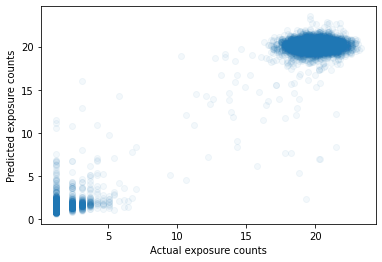

In [133]:
test_exp_labels = [l[0] for _, l in test_dataset]
plt.scatter(test_exp_labels, np.array(predictions)[:, 0], alpha=0.05)
plt.xlabel("Actual exposure counts")
plt.ylabel("Predicted exposure counts")

Text(0, 0.5, 'Predicted outcome counts')

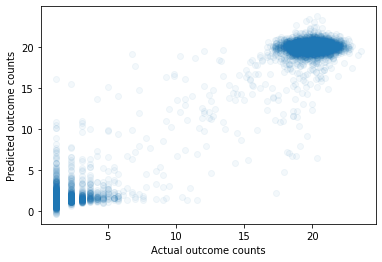

In [134]:
test_out_labels = np.array([l[1] for _, l in test_dataset])

plt.scatter(test_out_labels, np.array(predictions)[:, 1], alpha=0.05)
plt.xlabel("Actual outcome counts")
plt.ylabel("Predicted outcome counts")

# Generating a variants test set

In [135]:
test_sim_data = synthetic.read_simdata_file(raw_simulation_data_fpath)

In [136]:
variants_mapping = {}

nts_to_ints = { 'A':0, 'C':1, 'G':2, 'T':3 } 
ints_to_nts = {i: nt for nt, i in nts_to_ints.items()} 

def mutate_nt(nt):
     return ints_to_nts[(nts_to_ints[nt] + np.random.choice([1, 2, 3])) % 4]

def mutate_sequence(seq, embedding):
    start_pos = embeddings[0].startPos
    embedded_seq = embeddings[0].what.string
    mutation_pos = start_pos + np.random.choice(np.arange(len(embedded_seq)))
    new_nt = mutate_nt(sequence[mutation_pos])      
    new_sequence = sequence[:mutation_pos] + new_nt + sequence[mutation_pos+1:]
    return new_sequence

zipped_sim_data = zip(test_sim_data.sequences, test_sim_data.labels, test_sim_data.embeddings)
for i, (sequence, labels, embeddings) in enumerate(zipped_sim_data):    # One of two motifs embedded
    if len(embeddings) == 1:
        new_sequence = mutate_sequence(sequence, embeddings[0])
        assert new_sequence not in variants_mapping
        assert editdistance.eval(sequence, new_sequence) == 1
        variants_mapping[new_sequence] = i
    elif len(embeddings) == 3:
        new_sequence = mutate_sequence(mutate_sequence(sequence, embeddings[0]), embeddings[1])
        assert new_sequence not in variants_mapping
        assert editdistance.eval(sequence, new_sequence) == 1
        variants_mapping[new_sequence] = i
    else:
        assert len(embeddings) == 0

In [137]:
variants_test_set = []

motifs = synthetic.LoadedEncodeMotifs(
    simdna.ENCODE_MOTIFS_PATH, pseudocountProb=0.001
)
exposure_pwm = motifs.loadedMotifs[exposure_motif].getRows()
outcome_pwm = motifs.loadedMotifs[outcome_motif].getRows()

for variant_seq, original_idx in variants_mapping.items():
    labels = simulate_oracle_predictions(
        [variant_seq],
        exposure_pwm,
        outcome_pwm,
    )
    variants_test_set.append({
        "sequences": variant_seq,
        "original_idx": original_idx,
        "labels_exp": labels[0][0],
        "labels_out": labels[1][0]
    })

In [138]:
variants_df = pd.DataFrame(variants_test_set)
variants_df.head()

,sequences,original_idx,labels_exp,labels_out
0,TCCAGATAAGTCGCATTTTTTCAGCAATTCCAAGAAATAATGTTTC...,0,94,110
1,ATCAACACATGGCTCCTAAGTAATAATTAGCTGTGGAATCGACTGA...,1,8,3
2,CCTGGATATGCTCCCCGGAGAACATATGGCGTGCAGACCTTTCATG...,2,26,21
3,CAATACGAACCTCTTCTTGTGATAAGGGTTGTTGCCTGCATGCCCC...,3,120,106
4,CCGCTCTCGATTATTTATTAGGTTGGTGGGTTGAATCACCGGATAA...,4,59,0


In [139]:
original_variant_rows = test_df.iloc[variants_df['original_idx'], :].reset_index().copy()
original_variant_rows = original_variant_rows.rename(
    columns={'labels_exp': 'original_labels_exp', 'labels_out': 'original_labels_out'}
)
original_variant_rows = original_variant_rows.drop(columns=["sequences"])

In [140]:
variants_df = pd.concat((variants_df, original_variant_rows), axis=1)


In [141]:
variants_test_dataset = IterablePandasDataset(
    variants_df, x_cols=sequences_col, y_cols=label_cols, x_transform=one_hot, y_transform=anscombe_transform
)
variants_test_data_loader = torch.utils.data.DataLoader(
    variants_test_dataset, batch_size=batch_size, num_workers=0
)

In [142]:
variant_predictions, losses, metrics = run_one_epoch(
    model, variants_test_data_loader, None, training=False, metrics_config={
        "spearman-rho": spearman_rho,
        "r-squared": rsquared,
        "pearson-r": pearson_r,
    }
)
metrics

{'spearman-rho': [0.7532793618868411, 0.7265868036067402],
 'r-squared': array([0.23086838, 0.0665861 ]),
 'pearson-r': [0.6342877024853952, 0.7156740457258336]}

Text(0, 0.5, 'Predicted exposure counts')

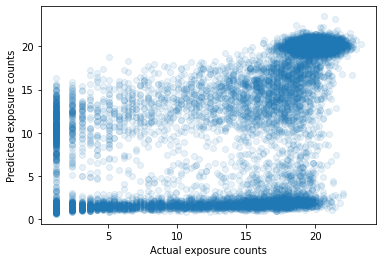

In [143]:
plt.scatter(np.array([l[0] for _, l in variants_test_dataset]), np.array(variant_predictions)[:, 0], alpha=0.1)
plt.xlabel("Actual exposure counts")
plt.ylabel("Predicted exposure counts")

Text(0, 0.5, 'Predicted outcome counts')

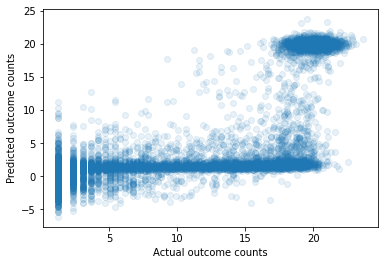

In [144]:
plt.scatter(np.array([l[1] for _, l in variants_test_dataset]), (np.array(variant_predictions)[:, 1]), alpha=0.1)
plt.xlabel("Actual outcome counts")
plt.ylabel("Predicted outcome counts")

In [145]:
real_exp_variant_effects = (
    anscombe_transform(variants_df['labels_exp']) - anscombe_transform(variants_df['original_labels_exp'])
)
real_out_variant_effects = (
    anscombe_transform(variants_df['labels_out']) - anscombe_transform(variants_df['original_labels_out'])
)
predicted_variant_effects = np.array(variant_predictions) - np.array([predictions[i] for i in variants_df['original_idx']])

Text(0, 0.5, 'Predicted exposure variant effect')

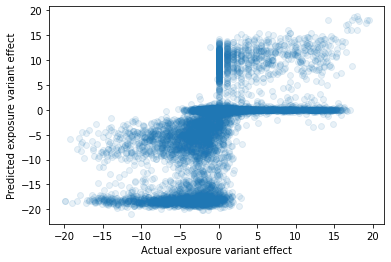

In [146]:
plt.scatter(real_exp_variant_effects, predicted_variant_effects[:, 0], alpha=0.1)
plt.xlabel("Actual exposure variant effect")
plt.ylabel("Predicted exposure variant effect")

Text(0, 0.5, 'Predicted outcome variant effect')

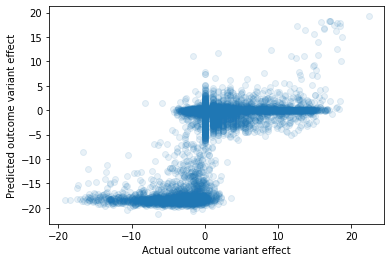

In [147]:
plt.scatter(real_out_variant_effects, predicted_variant_effects[:, 1], alpha=0.10)
plt.xlabel("Actual outcome variant effect")
plt.ylabel("Predicted outcome variant effect")

In [148]:
print("Exposure veffs pearson R: ", pearson_r(real_exp_variant_effects, predicted_variant_effects[:, 0]))
print("Exposure veffs R^2: ", rsquared(real_exp_variant_effects, predicted_variant_effects[:, 0]))
print("Exposure veffs spearman: ", spearman_rho(real_exp_variant_effects, predicted_variant_effects[:, 0]))

Exposure veffs pearson R:  0.5746101261469041
Exposure veffs R^2:  [-1.14366051]
Exposure veffs spearman:  0.6633754282648645


In [149]:
print("Outcome veffs pearson R: ", pearson_r(real_out_variant_effects, predicted_variant_effects[:, 1]))
print("Outcome veffs R^2: ", rsquared(real_out_variant_effects, predicted_variant_effects[:, 1]))
print("Outcome veffs spearman: ", spearman_rho(real_out_variant_effects, predicted_variant_effects[:, 1]))

Outcome veffs pearson R:  0.5775369083365592
Outcome veffs R^2:  [-1.47729643]
Outcome veffs spearman:  0.4769779994131085


In [150]:
ss_ref = np.sum((real_out_variant_effects - predicted_variant_effects[:, 1])**2)
ss_out = np.sum((real_out_variant_effects - np.mean(real_out_variant_effects))**2)
1 - ss_ref / ss_out

-1.4772964307143477